In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from statsmodels.stats import diagnostic
import statsmodels.stats as st
from scipy import stats
from itertools import combinations
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
import missingno as msno
import ast
from collections import Counter
import statsmodels.regression.recursive_ls as rls
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyvis.network import Network
from director_scrap import director_scrap

%load_ext autoreload
%autoreload 2

# I - **Database manager**

In this section we add and process the imdb database. \
First let us depict some general characteristics of the imdb dataset that will help us undertsand it. \
The imdb database is constituted of 5 different <code>*.tsv</code> files, films and persons (actors, directors...) are represented by a unique alphanumeric string named respectively <code>tconst</code> and  <code>nconst</code>.

### **Crew**

**tconst (string)** - alphanumeric unique identifier of the title \
**directors (array of nconsts)** - director(s) of the given title \
**writers (array of nconsts)** – writer(s) of the given title 

In [11]:
df_crew = pd.read_table('data/crew.tsv')
df_crew.head(1)

,tconst,directors,writers
0,tt0000001,nm0005690,\N


We will keep the columns <code>['directors', 'writers']</code>, we think they are important features to determine the success of a movie.

### **Name**

**nconst (string)** - alphanumeric unique identifier of the name/person \
**primaryName (string)** – name by which the person is most often credited \
**birthYear** – in YYYY format \
**deathYear** – in YYYY format if applicable, else '\N' \
**primaryProfession (array of strings)** – the top-3 professions of the person \
**knownForTitles (array of tconsts)** – titles the person is known for 

In [6]:
df_name = pd.read_table('data/name.tsv')
df_name.head(1)

FileNotFoundError: [Errno 2] No such file or directory: 'data/name.tsv'

We will keep the column <code>['primaryName']</code>, we are trying to retrieve the names only (for the directors, writers...)

### **Title**

**tconst (string)** - alphanumeric unique identifier of the title \
**titleType (string)** – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc) \
**primaryTitle (string)** – the more popular title / the title used by the filmmakers on promotional materials at the point of release \
**originalTitle (string)** - original title, in the original language \
**isAdult (boolean)** - 0: non-adult title; 1: adult title \
**startYear (YYYY)** – represents the release year of a title. In the case of TV Series, it is the series start year \
**endYear (YYYY)** – TV Series end year. ‘\N’ for all other title types \
**runtimeMinutes** – primary runtime of the title, in minutes \
**genres (string array)** – includes up to three genres associated with the title

In [7]:
df_title = pd.read_table('data/title.tsv')
df_title.head(1)

FileNotFoundError: [Errno 2] No such file or directory: 'data/title.tsv'

We will keep the column <code>['primaryTitle', 'startYear']</code>, we want the name of the movie so we can merge it on our primary database. We also keep the release year beacuse two movies with the same title might have been released at different years (remaster), without it we cannot differentiate them.

### **Rating**

**tconst (string)** - alphanumeric unique identifier of the title \
**averageRating** – weighted average of all the individual user ratings \
**numVotes** - number of votes the title has received

In [8]:
df_rating = pd.read_table('data/imdb_rating.tsv')
df_rating.head(1)

FileNotFoundError: [Errno 2] No such file or directory: 'data/imdb_rating.tsv'

We will keep the column <code>['averageRating']</code>, doing analysis on the rating instead of the revenue only might give us more insight on how to determine a succesful movie.

### **Principals**

**tconst (string)** - alphanumeric unique identifier of the title \
**ordering (integer)** – a number to uniquely identify rows for a given titleId \
**nconst (string)** - alphanumeric unique identifier of the name/person \
**category (string)** - the category of job that person was in \
**job (string)** - the specific job title if applicable, else '\N' \
**characters (string)** - the name of the character played if applicable, else '\N'

In [9]:
df_principals = pd.read_table('data/principals.tsv')
df_principals.head(1)

FileNotFoundError: [Errno 2] No such file or directory: 'data/principals.tsv'

For simplicity, we will only keep the producers and composers. We could add more later but we think it is better for a first analysis. In the same spirit, we only keep one person per role : if there is multiple producers we will keep only one of them at random.

## **Merging the imdb databases**

Here we will merge the databases loaded above

In [10]:
#Drop useless informations
df_p = df_principals.drop(['job', 'characters', 'ordering'], axis=1)

#Keep only one person per role
df_p_drop = df_p.drop_duplicates(subset=['tconst', 'category'])

#Pivot the dataframe so we have the each role in column format for a given movie
df_pp = df_p_drop.pivot(index='tconst', columns='category', values='nconst').reset_index()

#Keep only composer and producer
df_roles = df_pp[['tconst', 'composer', 'producer']]

#Retrieve the names for the roles via the 'Name' database
df_co = df_roles.merge(df_name, left_on='composer', right_on='nconst', how='inner')
df_co = df_co[['tconst', 'producer', 'primaryName']].rename(columns={'primaryName': 'Composer'})
df_prod = df_co.merge(df_name, left_on='producer', right_on='nconst', how='inner')
df_prod = df_prod[['tconst', 'primaryName', 'Composer']].rename(columns={'primaryName': 'Producer'})

#Print the result
df_prod.head(1)

NameError: name 'df_principals' is not defined

In [ ]:
#Associate movie rating with crew
df_crew_rating = df_crew.merge(df_rating, how='inner', on='tconst')
df_cr = df_crew_rating.drop(['numVotes'], axis=1)

#Associate the name of the movie to the rest
df_cr_title = df_cr.merge(df_title[['tconst', 'primaryTitle', 'startYear']], how='inner', on='tconst')

#Add the composer and producer
df_t = df_cr_title.merge(df_prod, on='tconst', how='left')

#Add the director
df_crt_dir = df_t.merge(df_name[['nconst', 'primaryName']], left_on='directors', right_on='nconst', how='inner')

#Add the writer
df_fin = df_crt_dir.merge(df_name[['nconst', 'primaryName']], left_on='writers', right_on='nconst', how='left')

df_fin.head(1)

,tconst,directors,writers,averageRating,primaryTitle,startYear,Producer,Composer,nconst_x,primaryName_x,nconst_y,primaryName_y
0,tt0000001,nm0005690,NaN,5.7,Carmencita,1894.0,NaN,NaN,nm0005690,William K.L. Dickson,NaN,NaN


## **Clean the database**

We simply will drop duplicates, drop some columns and rename some others to have a very clean tool to work with !

In [ ]:
#Drop useless columns
df_dropped = df_fin.drop(['tconst', 'directors', 'writers', 'nconst_x', 'nconst_y'], axis=1)

#Rename columns
df_renamed = df_dropped.rename(columns={"primaryName_x": "Director", 
                                       "primaryName_y": "Writer", 
                                       "averageRating": "Movie_rating",
                                        "startYear": "Movie_release",
                                       "primaryTitle": "Movie_name"})
#Remove general duplicates
df_no_gen_dup = df_renamed.drop_duplicates()

#Remove duplicate movies
df_imdb = df_no_gen_dup.drop_duplicates(subset=['Movie_name', 'Movie_release'])

#Print the imdb database
df_imdb.head(1)

,Movie_rating,Movie_name,Movie_release,Producer,Composer,Director,Writer
0,5.7,Carmencita,1894.0,NaN,NaN,William K.L. Dickson,NaN


# II - **Analysis**

Now we will do some analysis with our main data given by the CMU movie corpus

In [ ]:
# Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie name
# 4. Movie release date
# 5. Movie box office revenue
# 6. Movie runtime
# 7. Movie languages (Freebase ID:name tuples)
# 8. Movie countries (Freebase ID:name tuples)
# 9. Movie genres (Freebase ID:name tuples)

columns_mov = ['Wiki_ID', 'Freebase_ID', 'Movie_name', 'Movie_release', 'Movie_revenue', 'Movie_runtime', 
               'Movie_languages', 'Movie_countries', 'Movie_genres']
df_mov = pd.read_table('data/movie.metadata.tsv', header=None, names=columns_mov)
df_mov.head(1)

,Wiki_ID,Freebase_ID,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


In [ ]:
# Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie release date
# 4. Character name
# 5. Actor date of birth
# 6. Actor gender
# 7. Actor height (in meters)
# 8. Actor ethnicity (Freebase ID)
# 9. Actor name
# 10. Actor age at movie release
# 11. Freebase character/actor map ID
# 12. Freebase character ID
# 13. Freebase actor ID

columns_char = ['Wiki_ID', 'Freebase_ID', 'Movie_release', 'Char_name', 'Actor_birth', 'Actor_gender', 
               'Actor_height', 'Actor_ethnicity', 'Actor_name', 'Actor_age_release', 'Char/Actor_map', 
               'Char_ID', 'Actor_ID']
df_char = pd.read_table('data/character.metadata.tsv', header=None, names=columns_char)
df_char.head(1)

,Wiki_ID,Freebase_ID,Movie_release,Char_name,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release,Char/Actor_map,Char_ID,Actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7


In [ ]:
#ANOMALY FOUND IN THE DATABASE, MOVIE RELEASE IN 1010-12-02
df_mo22 = df_mov[df_mov["Movie_name"] == "Hunting Season"]
# Correction
df_mov.loc[df_mov["Movie_name"] == "Hunting Season", "Movie_release"] = "2010-12-02"

## **1. Processing of the data**

### **1.1 Character data**

First, we clean the data, and use some predictors to replace the missing values.

We directly notice that our data is full of missing values, for the proportion of lines that we see above. So we will try to count how many of them they are, in order to take measure for them.

In [ ]:
df_char.isnull().sum()

Wiki_ID                   0
Freebase_ID               0
Movie_release          9995
Char_name            257875
Actor_birth          106145
Actor_gender          45609
Actor_height         295845
Actor_ethnicity      344611
Actor_name             1228
Actor_age_release    158113
Char/Actor_map            0
Char_ID              257865
Actor_ID                815
dtype: int64

We see that our data is incomplete, especially for the actors' ethnicities and birth dates. The percentage of missing data is pretty high so we have to be careful with our analysis around certain features.

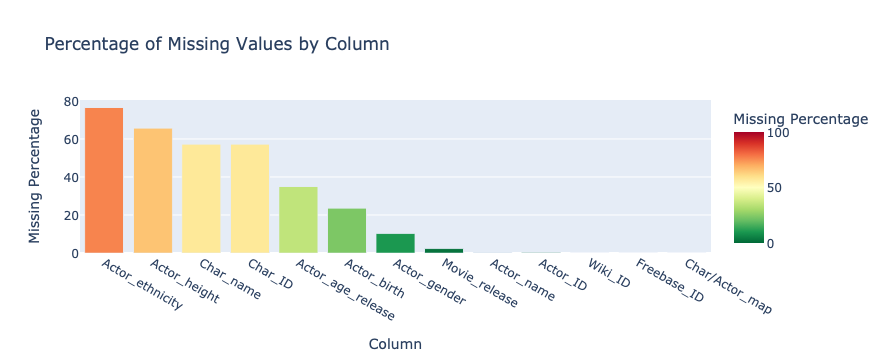

In [ ]:
# Calculate, sort, and round the missing percentages
missing_percentage = (df_char.isnull().sum() / len(df_char) * 100).sort_values(ascending=False).round(2)

# Convert the Series to DataFrame for compatibility with plotly
df_missing = missing_percentage.reset_index()
df_missing.columns = ['Column', 'Missing Percentage']

# Create the plot with a specified color range
fig = px.bar(df_missing, x='Column', y='Missing Percentage', 
             color='Missing Percentage', 
             color_continuous_scale="RdYlGn_r", 
             range_color=[0, 100],  # Specifying the color scale range
             title='Percentage of Missing Values by Column')
fig.update_layout(coloraxis_colorbar=dict(title="Missing Percentage"))
fig.show()

<Axes: >

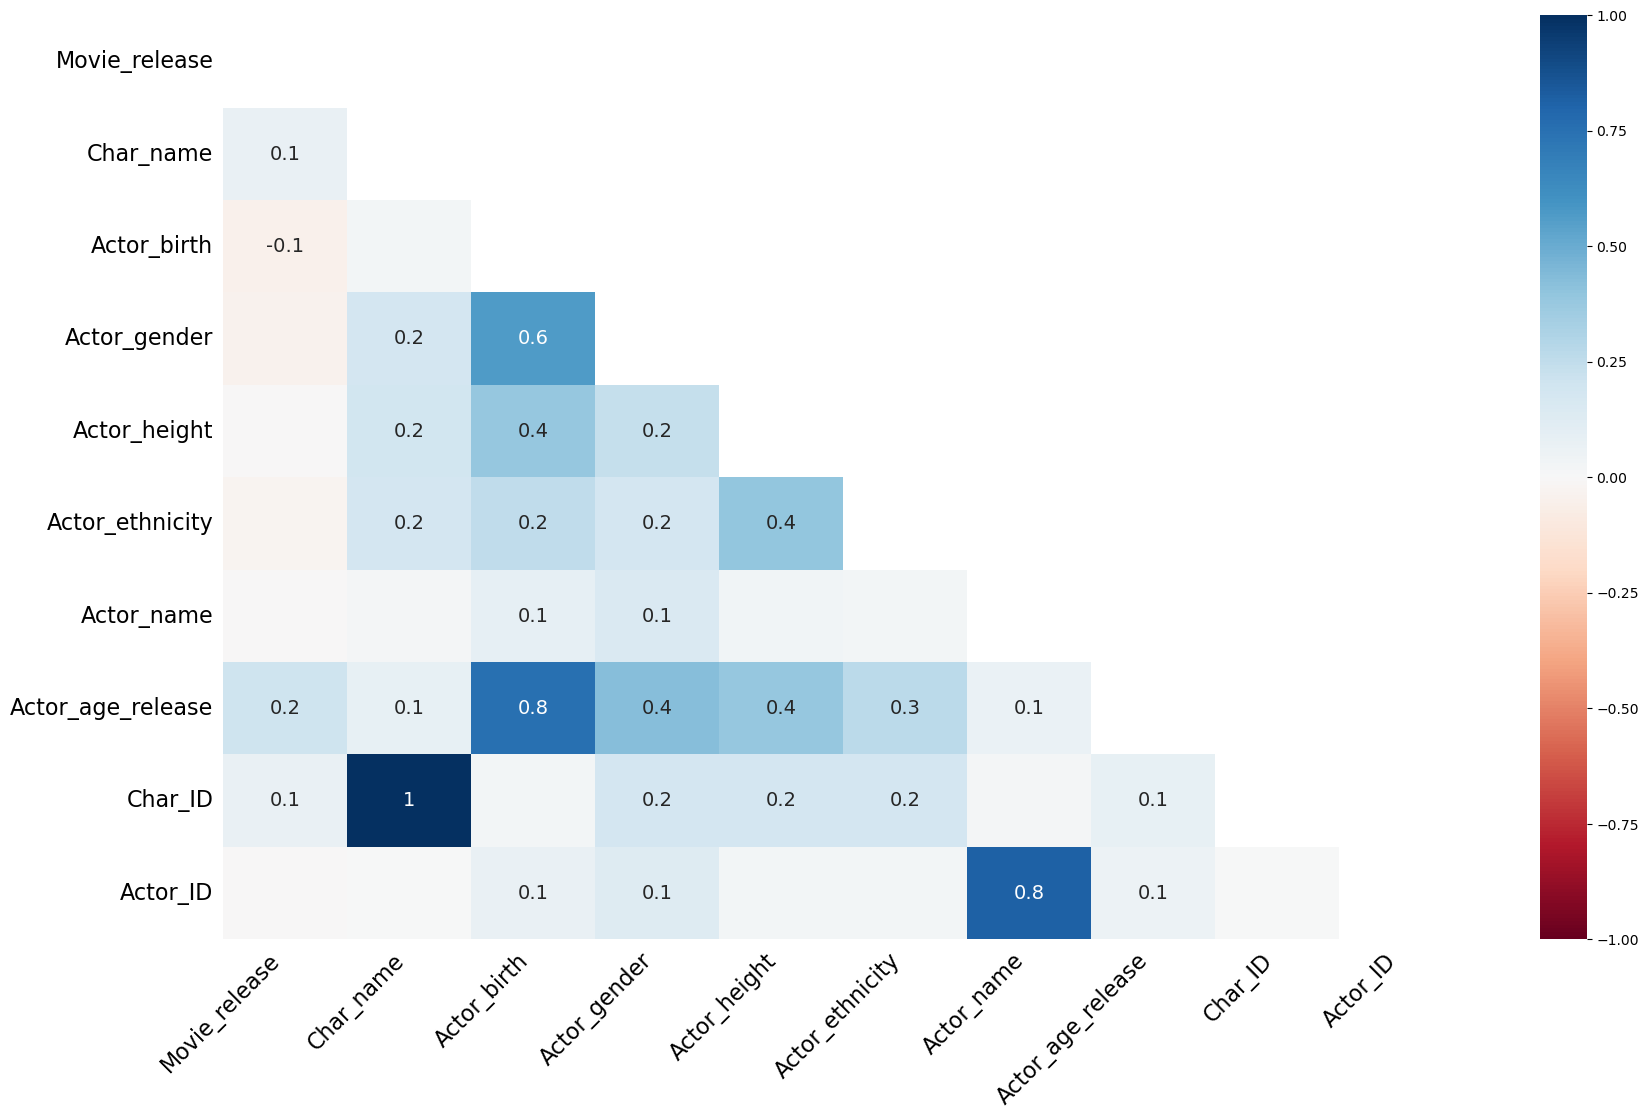

In [ ]:
msno.heatmap(df_char)

Observing all the missing features, the more personnal the feature is for the actor, the less present it is in percentage. We can explain this phenomenom simply because it is harder to report theses data in a database because they're harder to find for each actor. For example, Actor_age_release missing values has 0.8 correlation with Actor_birth missing values which makes sense !

In [ ]:
# drop records which contain missing values
data_dropped = df_char.dropna()
print("Number of rows after dropping missing records: ", len(data_dropped))

Number of rows after dropping missing records:  45264


We can still see that there is still a big number of rows where not a single feature is missing, so we could work with this dataframe if we wanted to analyse things around personnal actors characterics.

### **1.2 Movie data**

In the same manner, we can analyse our movie data :

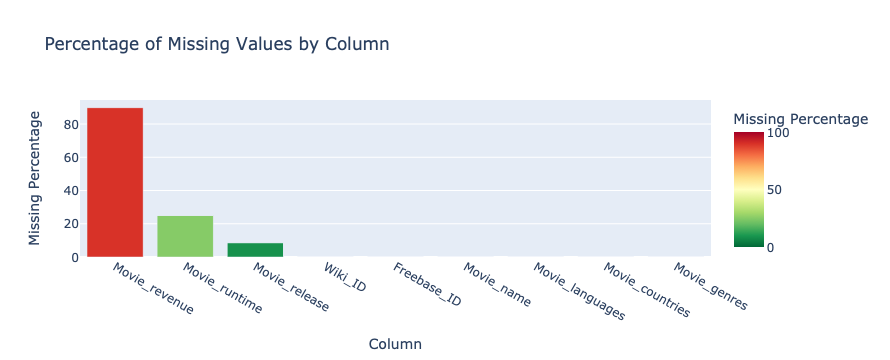

In [ ]:
# Calculate, sort, and round the missing percentages
missing_percentage = (df_mov.isna().sum() / len(df_mov) * 100).sort_values(ascending=False).round(2)

# Convert the Series to DataFrame for compatibility with plotly
df_missing = missing_percentage.reset_index()
df_missing.columns = ['Column', 'Missing Percentage']

# Create the plot with a specified color range
fig = px.bar(df_missing, x='Column', y='Missing Percentage', 
             color='Missing Percentage', 
             color_continuous_scale="RdYlGn_r", 
             range_color=[0, 100],  # Specifying the color scale range
             title='Percentage of Missing Values by Column')
fig.update_layout(coloraxis_colorbar=dict(title="Missing Percentage"))
fig.show()

<Axes: >

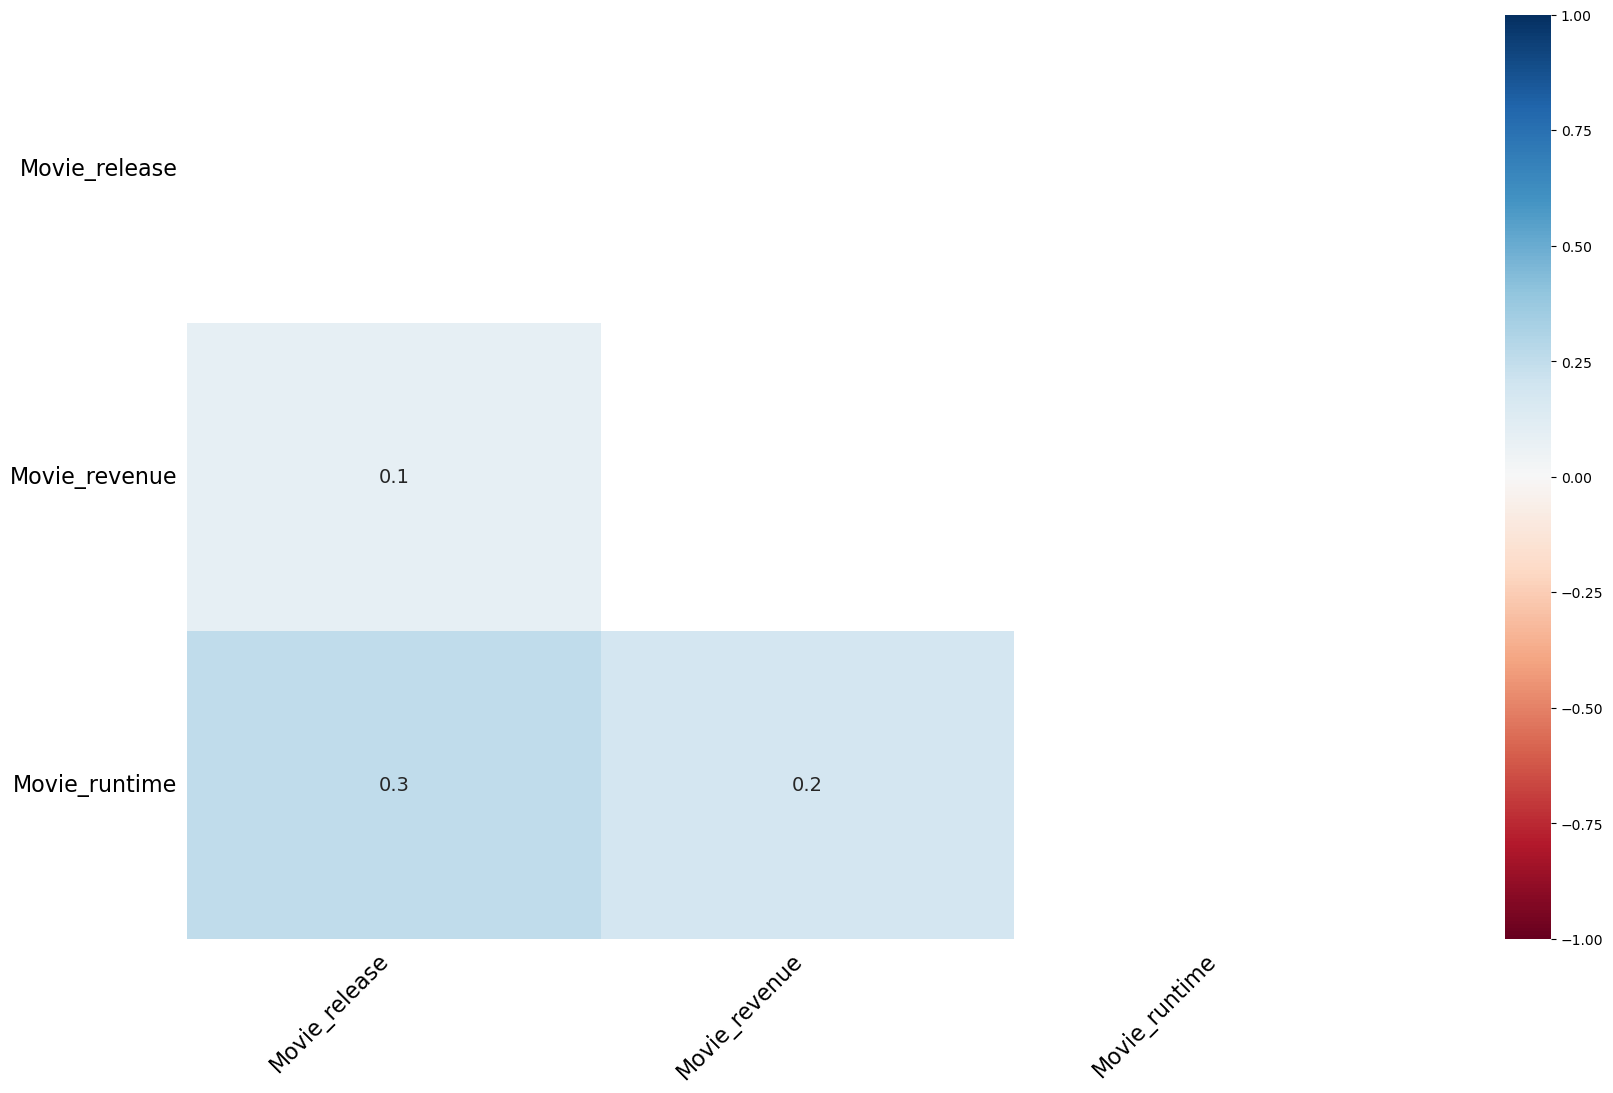

In [ ]:
msno.heatmap(df_mov)

We can see that on the other hand, the movie data is quite complete. Therefore any analysis will be considered relevant around this data.

### **1.3 Revenue analysis around month of release**

For the month of the release, we can ask ourselves which month might be the most favorable one to release your movie. We can categorize each movie into separate bins based on two criteria: firstly, the first two genres they appear to belong to, and secondly, the month in which they were released. \
Inflation is negligeable here because we analyse the problem around months of each year which directly normalizes the revenues.

In [ ]:
# Convert string representation of a dictionary to an actual dictionary
df_mov['Genre_dict'] = df_mov['Movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})

# Extract genres
df_mov['Main_genre'] = df_mov['Genre_dict'].apply(lambda x: list(x.values())[0] if len(x) > 0 else None)
df_mov['Sec_Genre'] = df_mov['Genre_dict'].apply(lambda x: list(x.values())[1] if len(x) > 1 else None)

#Copy
df_mov1 = df_mov.copy()

# Drop the temporary Genre_dict column
df_mov1.drop(columns=['Genre_dict'], inplace=True)

df_mov1['Movie_release'] = pd.to_datetime(df_mov1['Movie_release'], errors='coerce')

# Extract year, month, and day into new columns
df_mov1['Year_of_release'] = df_mov1['Movie_release'].dt.year
df_mov1['Month_of_release'] = df_mov1['Movie_release'].dt.month

Now that we separated the month from the movie release date, we can plot analysis using them :

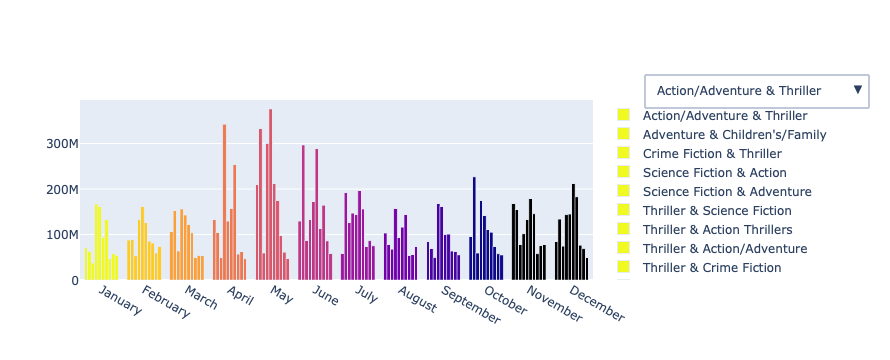

In [ ]:
# Calculate mean revenue for each genre pair
genre_pair_mean_revenue = df_mov1.groupby(['Main_genre', 'Sec_Genre'])['Movie_revenue'].mean().reset_index()

# Merge this mean revenue with the original df_mov1 on 'Main_genre' and 'Sec_Genre'
df_mov1 = df_mov1.merge(genre_pair_mean_revenue, on=['Main_genre', 'Sec_Genre'], suffixes=('', '_mean'))

# Fill NaN values in 'Movie_revenue' with the mean revenue of the genre pairs
df_mov1['Movie_revenue'] = df_mov1['Movie_revenue'].fillna(df_mov1['Movie_revenue_mean'])

# Drop the auxiliary 'Movie_revenue_mean' as it's no longer needed after the NaN values are filled
df_mov1.drop(columns=['Movie_revenue_mean'], inplace=True)

# Drop rows where either 'Main_genre' or 'Secondary_Genre' is NaN
df_genre_pairs = df_mov1.dropna(subset=['Main_genre', 'Sec_Genre'])

# Drop rows where either 'Main_genre' or 'Secondary_Genre' is 'Short Film'
df_genre_pairs = df_genre_pairs[(df_genre_pairs['Main_genre'] != 'Short Film') & (df_genre_pairs['Sec_Genre'] != 'Short Film')]

month_dict = {
    1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
    7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"
}

# Create the 'genre_pairs_aggregated' DataFrame with 'count' and 'mean_revenue' as columns
genre_pairs_aggregated = df_genre_pairs.groupby(['Main_genre', 'Sec_Genre']).agg(
    count=('Wiki_ID', 'size'), 
    mean_revenue=('Movie_revenue', 'mean')
).reset_index()

top_10_genre_pairs = genre_pairs_aggregated[genre_pairs_aggregated['count'] >= 150].sort_values(by='mean_revenue', ascending=False).head(10)

# Sort the top_10_genre_pairs list alphabetically by main genre only# 'top_10_genre_pairs' would be a DataFrame here, you need to extract the genre pairs as a list of tuples
top_10_genre_pairs_list = top_10_genre_pairs[['Main_genre', 'Sec_Genre']].values.tolist()

# Then, sort the list of tuples based on the main genre
top_10_genre_pairs_sorted_by_main_genre = sorted(top_10_genre_pairs_list, key=lambda x: x[0])

# Create an empty subplot
fig = make_subplots(rows=1, cols=1, shared_yaxes=True)

# Loop through each of the top 10 genre pairs
for main_genre, secondary_genre in top_10_genre_pairs_sorted_by_main_genre:
    pair_data = df_mov1[(df_mov1['Main_genre'] == main_genre) & (df_mov1['Sec_Genre'] == secondary_genre)]
    month_mean_revenues = pair_data.groupby('Month_of_release')['Movie_revenue'].mean().reset_index()
    month_mean_revenues['Month_of_release'] = month_mean_revenues['Month_of_release'].replace(month_dict)

    trace = go.Bar(x=month_mean_revenues['Month_of_release'],
                   y=month_mean_revenues['Movie_revenue'],
                   name=f"{main_genre} & {secondary_genre}",
                   opacity=1,
                   marker_color=px.colors.sequential.Plasma_r)

    fig.add_trace(trace)

# Create dropdown menu to switch between the sorted genre pairs
dropdown = []
for i, (main_genre, secondary_genre) in enumerate(top_10_genre_pairs_sorted_by_main_genre):
    # Each trace corresponds to a genre pair
    # For each button, only the corresponding trace should be visible
    visibility = [False] * len(top_10_genre_pairs_sorted_by_main_genre)
    visibility[i] = True  # Only the current trace is visible
    
    option = dict(label=f"{main_genre} & {secondary_genre}",
                  method='update',
                  args=[{'visible': visibility},
                        {'title': f'Mean Box Office Revenues by Month of Release for {main_genre} & {secondary_genre}'}])
    dropdown.append(option)

# Update layout with the sorted dropdown
fig.update_layout(
    updatemenus=[dict(
        type='dropdown',
        showactive=True,
        buttons=dropdown,  # Use the sorted dropdown list here
        direction="down",
        pad={"r": 10, "t": 10},
        x=1.1,
        xanchor="left",
        y=1.2,
        yanchor="top"
    )],
    # ... (keep the rest of your layout configuration as is)
)

From this graph we can see the general release trends for the 10 ten pairs of movie genres. The distributions are really unbalenced and and it is interesting for us data scientists ! \
As an example, we can see the Science Fiction & Action movies released in April and May have way higher revenues compared to the rest. \
However, we would need further investigation to conclude that the release month plays a role in the succes of a movie.

## **2. Merging all databases**

Here we will merge all our databases to start performing some analysis on succes of a collaboration between actors.

In [ ]:
df_mov_rel = df_mov.copy()

#Convert the date format into float for merging purposes
df_mov_rel['Movie_release'] = df_mov_rel['Movie_release'].apply(lambda x: float(str(x).split('-')[0]))

#Merge the imdb database with our main movie database
df_movie = df_mov_rel.merge(df_imdb, on=['Movie_release', 'Movie_name'], how='left')
df_movie = df_movie.drop(['Freebase_ID', 'Movie_genres', 'Genre_dict'], axis=1)

#Merge actor database
df_all = df_movie.merge(df_char, on='Wiki_ID', how='right')
df_all = df_all.drop(['Wiki_ID', 'Char/Actor_map', 'Char_ID', 'Actor_ID', 'Movie_release_y'], axis=1)

df_all.head()

,Movie_name,Movie_release_x,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Main_genre,Sec_Genre,Movie_rating,Producer,...,Director,Writer,Freebase_ID,Char_name,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release
0,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Thriller,Science Fiction,4.9,Sandy King,...,John Carpenter,NaN,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0
1,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Thriller,Science Fiction,4.9,Sandy King,...,John Carpenter,NaN,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0
2,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Thriller,Science Fiction,4.9,Sandy King,...,John Carpenter,NaN,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0
3,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Thriller,Science Fiction,4.9,Sandy King,...,John Carpenter,NaN,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0
4,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Thriller,Science Fiction,4.9,Sandy King,...,John Carpenter,NaN,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0


As seen in the data management and how the data is distributed, we choose to restrict ourselves the dataset to the movies that have been published in the US because maybe the alchemy might have different mechanisms over the continents or culture so we don’t really want confounders to come into play.

In [ ]:
#We will focus on the United States of America for our analysis as they contain the most non-nan values 
df_movie = df_all[df_all['Movie_countries'].str.contains("United States of America")]
print(f"The database has now {len(df_movie)} entries.")

The database has now 244240 entries.


The database has now 87654 entries.


<Axes: >

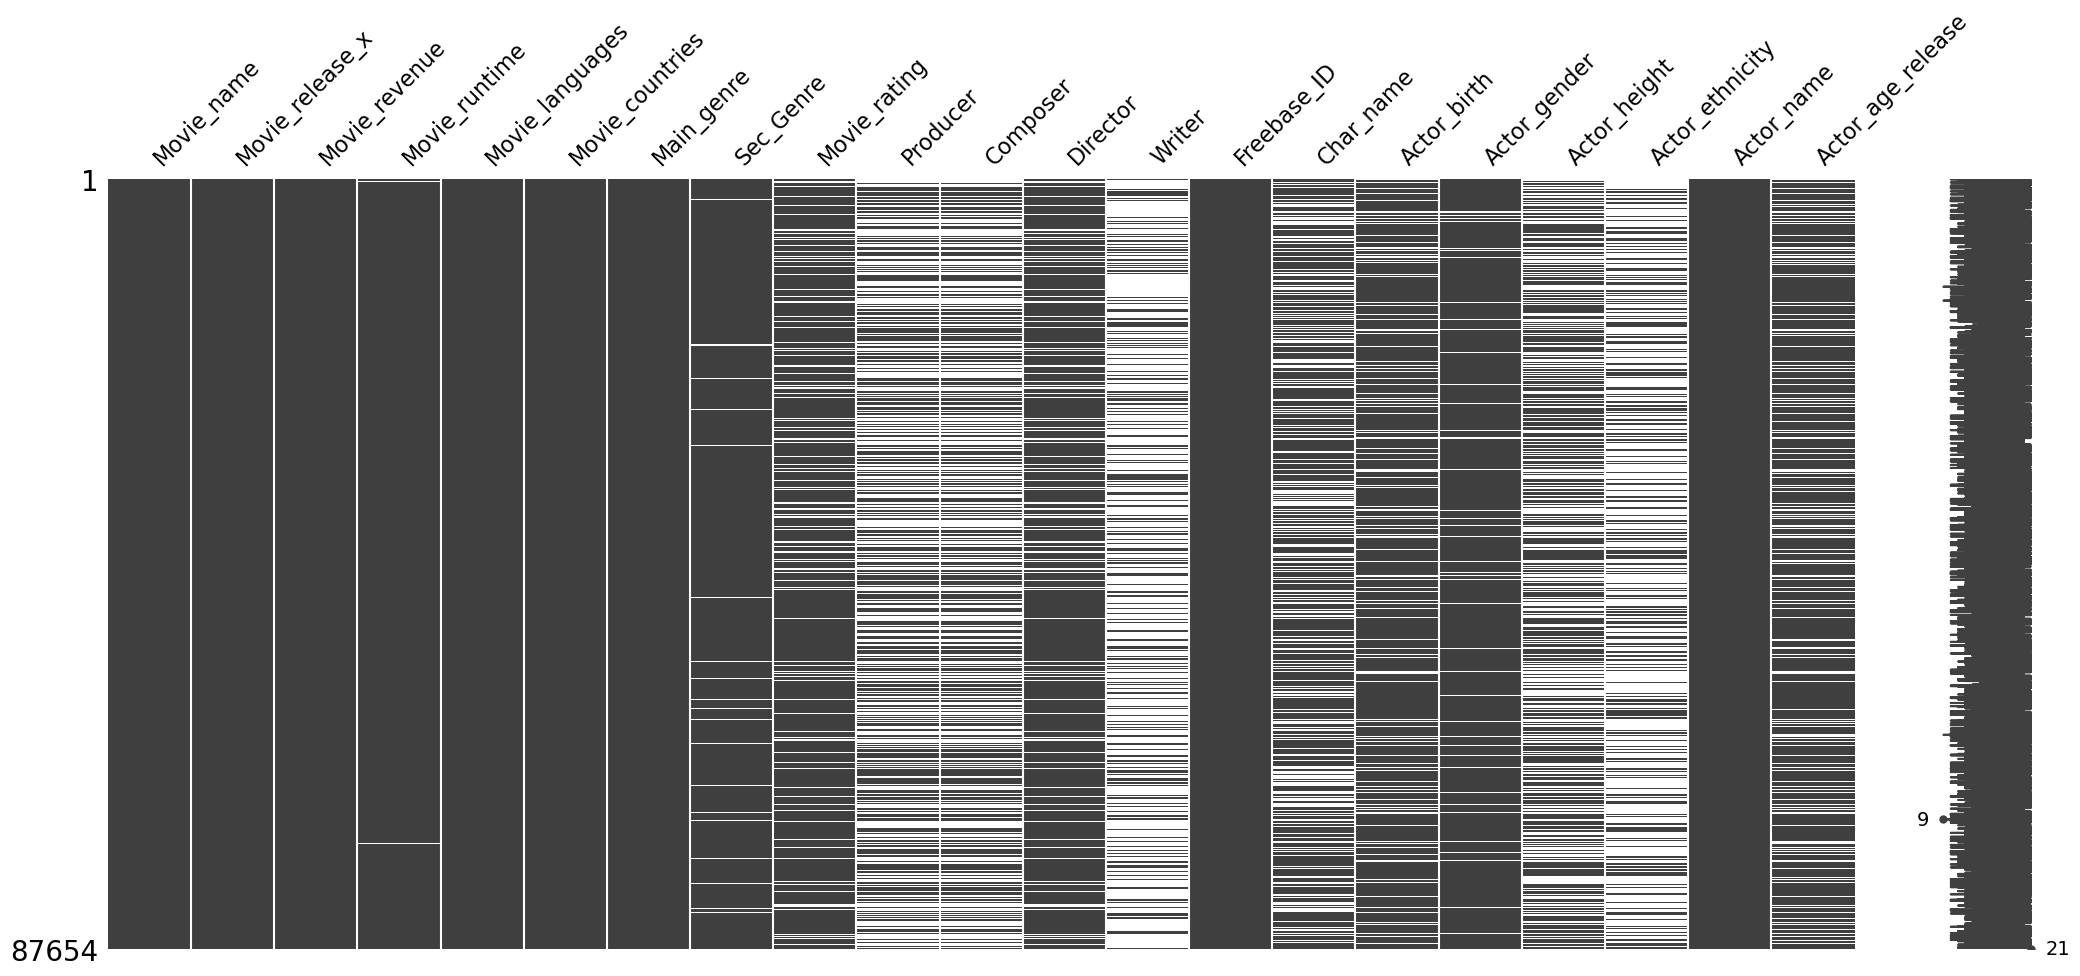

In [ ]:
df_movie = df_movie.dropna(subset=['Actor_name','Movie_name','Movie_revenue','Movie_release_x'])
print(f"The database has now {len(df_movie)} entries.")
msno.matrix(df_movie)

<Axes: >

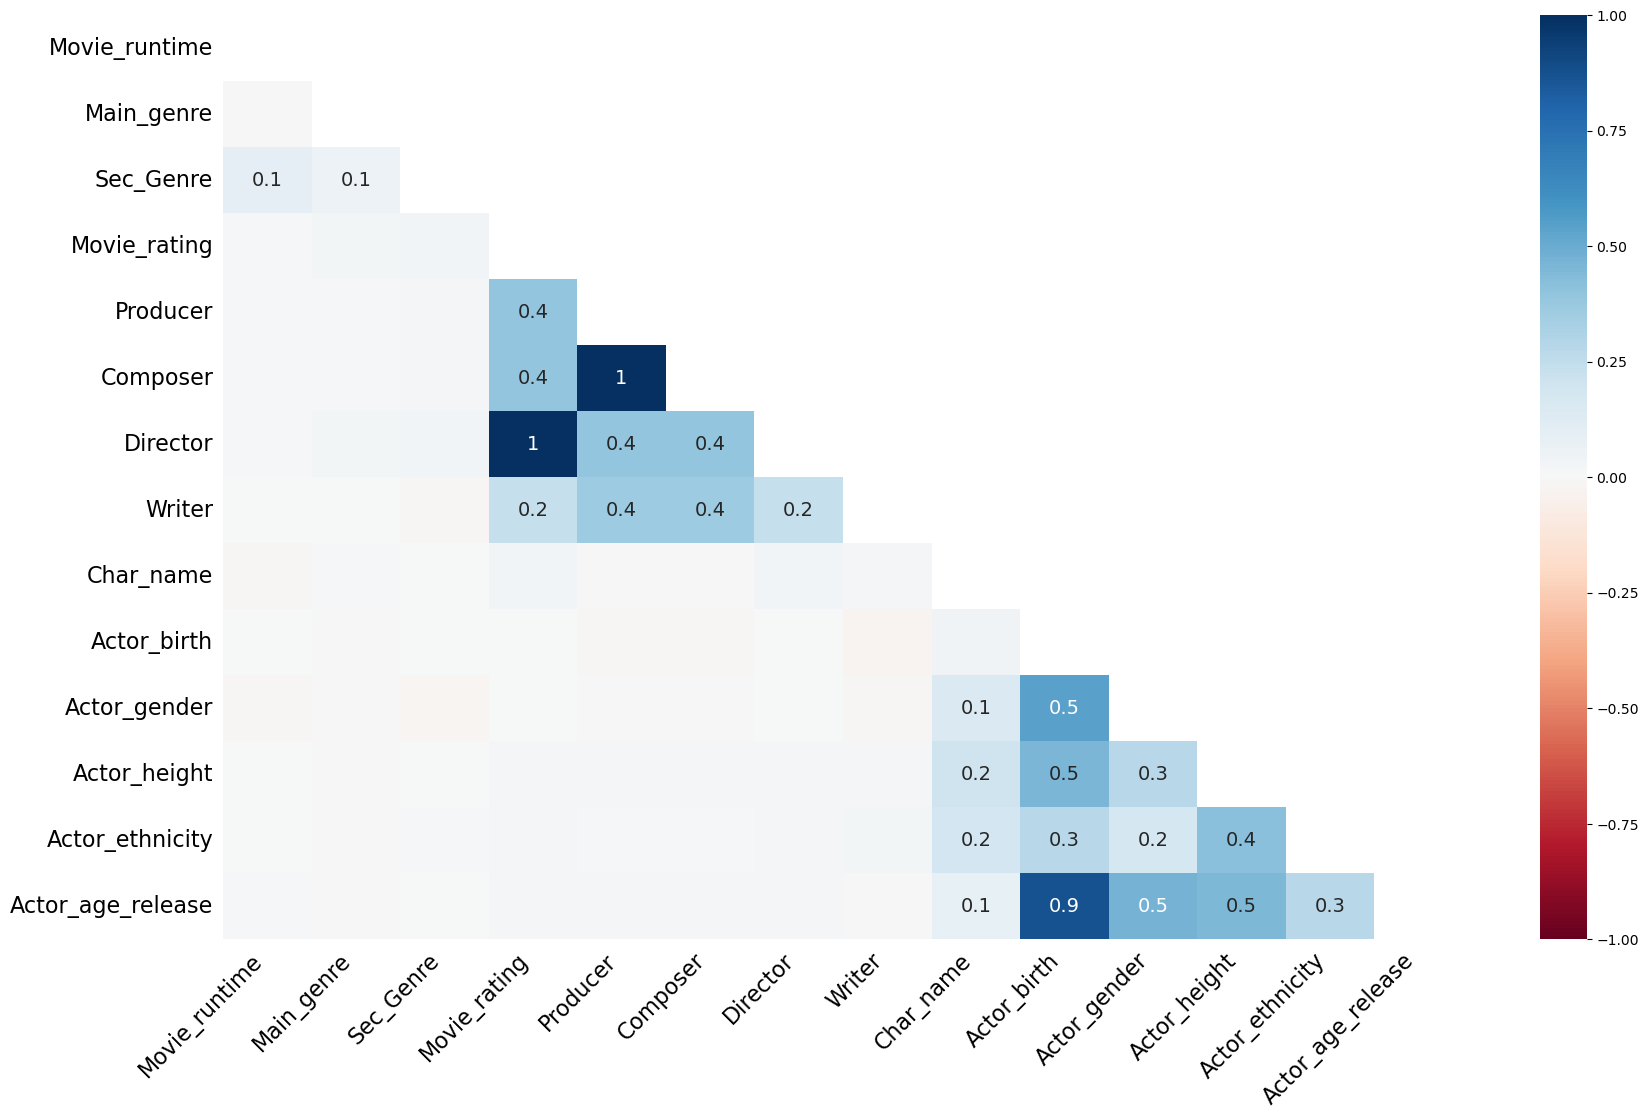

In [ ]:
msno.heatmap(df_movie)

## **3. First transformations around the data**

### **3.1 Inflation process**

First our database doesn't take into account inflation, so we the help of a verified online calculator, we created an inflation table so every revenue is similar to 2023 in inflation. For example, starting in the row of the first movie release (1888), we create a column giving us the value in 2023 of one dollar in 1888, which is 32.39$. Then we proceed for all the next years until 2023.
The transformation for each row is just about taking the year of release of the movie, go to his movie revenue and multiply it by the corresponding inflation factor.

In [ ]:
columns_inf = ['year', 'amount','inflation rate']
inflation = pd.read_table('data/inflation_data.csv', header=None, names=columns_inf,sep=',')
inflation = inflation.drop(index=0)

#From https://www.officialdata.org/us/inflation/1888?amount=1

value_in_2023 = [32.39,33.44,33.81,33.81,33.81,34.19,35.78,36.63,36.63,37.07,
                   37.07,37.07,36.63,36.20,35.78,34.96,34.57,34.96,34.19,32.73,
                   33.44,33.81,32.39,32.39,31.72,31.08,30.77,30.46,28.23,24.04,
                   20.38,17.78,15.38,17.19,18.31,17.99,17.99,17.58,17.38,17.68,
                   17.99,17.99,18.42,20.24,22.46,23.67,22.96,22.46,22.13,21.37,
                   21.82,22.13,21.98,20.93,18.88,17.78,17.48,17.09,15.78,13.80,
                   12.77,12.93,12.77,11.83,11.61,11.52,11.44,11.48,11.31,10.95,
                   10.65,10.57,10.39,10.29,10.19,10.05,9.92,9.77,9.50,9.21,8.84,
                   8.38,7.93,7.60,7.36,6.93,6.24,5.72,5.41,5.08,4.72,4.24,3.73,
                   3.38,3.19,3.09,2.96,2.86,2.81,2.71,2.60,2.48,2.35,2.26,2.19,
                   2.13,2.08,2.02,1.96,1.92,1.89,1.85,1.79,1.74,1.71,1.67,1.63,
                   1.58,1.53,1.48,1.43,1.43,1.41,1.37,1.34,1.32,1.30,1.30,1.28,
                   1.26,1.22,1.20,1.19,1.14,1.05,1]

inflation["Inflation Factor for 2023"] = value_in_2023
inflation["year"] = inflation["year"].astype(float)

df_movie['Inflation Factor for 2023'] = df_movie['Movie_release_x'].map(inflation.set_index('year')['Inflation Factor for 2023'])
df_movie['2023 valued revenue'] = df_movie['Movie_revenue'] * df_movie['Inflation Factor for 2023']

df_mood = df_movie.sort_values(by=['2023 valued revenue'],ascending = False)
df_mood.head(2)

,Movie_name,Movie_release_x,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Main_genre,Sec_Genre,Movie_rating,Producer,...,Freebase_ID,Char_name,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release,Inflation Factor for 2023,2023 valued revenue
257252,Snow White and the Seven Dwarfs,1937.0,416000000.0,84.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Romance Film,Musical,NaN,NaN,...,/m/0k4d7,Doc,1878-05-02,M,NaN,NaN,Roy Atwell,NaN,21.37,8.889920e+09
257258,Snow White and the Seven Dwarfs,1937.0,416000000.0,84.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Romance Film,Musical,NaN,NaN,...,/m/0k4d7,Happy,1865-12-29,M,NaN,NaN,Otis Harlan,NaN,21.37,8.889920e+09


Then we plot the difference between the Movie Revenue and the value of the Movie Revenue in 2023 :

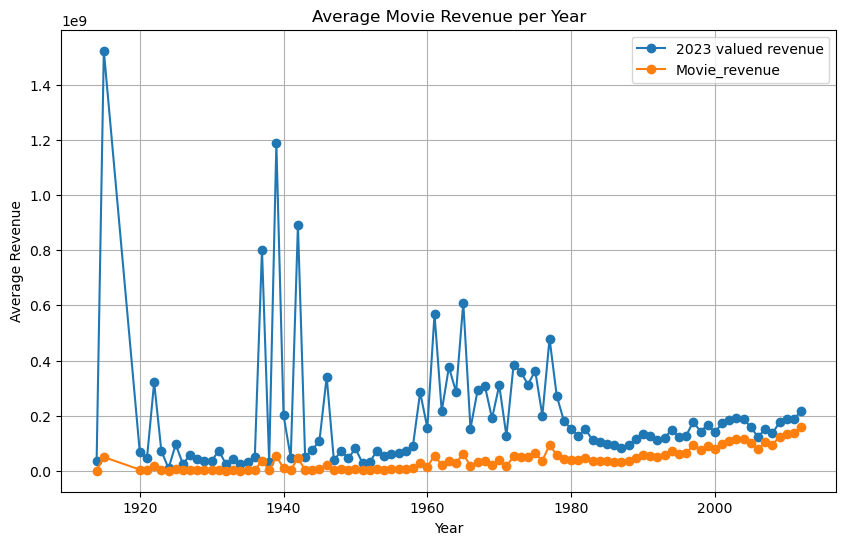

In [ ]:
# Group the DataFrame by year and calculate the average revenue for "Non-inflated revenue" and "Movie_revenue"
average_revenue = df_mood.groupby('Movie_release_x')[['2023 valued revenue', 'Movie_revenue']].mean()

# Extract the years and corresponding average revenue values
years = average_revenue.index
non_inflated_revenue = average_revenue['2023 valued revenue']
movie_revenue = average_revenue['Movie_revenue']

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(years, non_inflated_revenue, label='2023 valued revenue', marker='o')
plt.plot(years, movie_revenue, label='Movie_revenue', marker='o')

# Set labels and legend
plt.xlabel('Year')
plt.ylabel('Average Revenue')
plt.title('Average Movie Revenue per Year')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

We can see that the difference between the two are rather big, but it should be the correct representation of the success of a movie. \
It is interesting to see that movies in the 40s were really booming and that the most profitable movie of all time would be "Snow White and the Seven Dwarfs" and not "Avatar" like most of us believed.

### **3.2 Creating new columns derived on our data**

Theses new columns will help us to understand better the evolution of actors indiviudally. We will calculate the revenue, longevity in the industry, film count, and the average rating for each actor at the time of the release. We will be able to see which fe

In [ ]:
def calculate_avg_revenue(row, grouped_data):
    previous_films = grouped_data.get_group(row['Actor_name'])
    previous_films = previous_films[previous_films['Movie_release_x'] <= row['Movie_release_x']]
    if previous_films.empty:
        return np.nan
    else:
        return previous_films['Movie_revenue'].mean()
    
def calculate_longevity(row, grouped_data):
    first_film_date = grouped_data.get_group(row['Actor_name'])['Movie_release_x'].min()
    if (len(grouped_data.get_group(row['Actor_name'])['Movie_release_x']) == 0) : 
        return 0
    elif first_film_date == np.nan : 
        return np.nan
    else :
        return row['Movie_release_x'] - first_film_date

def calculate_films_count(row, grouped_data):
    previous_films = grouped_data.get_group(row['Actor_name'])
    return previous_films[previous_films['Movie_release_x'] <= row['Movie_release_x']].shape[0]

def calculate_avg_rating(row, grouped_data):
    previous_films = grouped_data.get_group(row['Actor_name'])
    previous_films = previous_films[previous_films['Movie_release_x'] <= row['Movie_release_x']]
    if previous_films.empty:
        return np.nan
    else:
        return previous_films['Movie_rating'].mean()

In [ ]:
#Create the actors subgroups
grouped_by_actor = df_movie.groupby('Actor_name')

#Create the new columns
df_movie['Avg_revenue_per_film_at_release'] = df_movie.apply(lambda row: calculate_avg_revenue(row, grouped_by_actor), axis=1)
df_movie['Longevity'] = df_movie.apply(lambda row: calculate_longevity(row, grouped_by_actor), axis=1)
df_movie['Number_of_film_at_release'] = df_movie.apply(lambda row: calculate_films_count(row, grouped_by_actor), axis=1)
df_movie['Avg_rating_per_film_at_release'] = df_movie.apply(lambda row: calculate_avg_rating(row, grouped_by_actor), axis=1)

# Ensure that Movie_release is sorted in ascending order for each actor
df_movie = df_movie.sort_values(by=['Actor_name', 'Movie_release_x'])

# Group by Actor_name and count the films in each group
df_movie['film_count'] = df_movie.groupby('Actor_name').cumcount()

# Add a new column boolean to see if this is the first film of an actor or not
df_movie['First_film'] = df_movie['film_count'] == 0
# Group by Actor_name and get the first release year for each actor
df_movie['first_movie_year'] = df_movie.groupby('Actor_name')['Movie_release_x'].transform('min')
# Create a new column 'First_film' which is True if 'Movie_release' is the same as 'first_movie_year'
df_movie['First_film'] = df_movie['Movie_release_x'] == df_movie['first_movie_year']

# Drop the useless columns
df_movie.drop('first_movie_year', axis=1, inplace=True)
df_movie.drop('film_count', axis=1, inplace=True)

In [ ]:
df_movie.columns

### **3.3 Creating dataframe with pairs of actors**

In [ ]:
# Group by 'Movie_name' and aggregate 'Actor_name' into lists
actor_pairs = df_movie.groupby(['Movie_name', 'Movie_release'])['Actor_name'].apply(list)

# For each movie, create all possible pairs of actors without duplication
actor_pairs = actor_pairs.apply(lambda x: list(combinations(sorted(set(x)), 2)))

df_pairs = pd.DataFrame(actor_pairs)
df_pairs = df_pairs.reset_index()
df_pairs = df_pairs.rename(columns={'Actor_name': 'Actor_pairs'})
df_pairs = df_pairs.explode('Actor_pairs')
df_pairs.head()

In [ ]:
df_pairs = df_pairs.merge(df_movie, on=['Movie_name', 'Movie_release'], how='left')

In [ ]:
def query_info_for_actor_pairs(row, df, infos):
    actor1 = row['Actor1']
    actor2 = row['Actor2']
    movie_name = row['Movie_name']
    movie_release = row['Movie_release']

    # Create a mask for the condition
    condition_mask = (df['Movie_name'] == movie_name) & (df['Movie_release'] == movie_release)

    # Filter the DataFrame based on the condition
    filtered_df = df[condition_mask]

    # Extract the relevant information for actor1 and actor2
    info1 = filtered_df.loc[filtered_df['Actor_name'] == actor1, infos].values.flatten()
    info2 = filtered_df.loc[filtered_df['Actor_name'] == actor2, infos].values.flatten()

    index = row.name

    print(f"Progress: {index / len(df_pairs) * 100:.2f}%")

    return info1, info2

In [ ]:
def all_infos(row):
    infos1, infos2 = query_info_for_actor_pairs(row, df_movie, ['Actor_age_release', 'Number_of_film_at_release', 'Avg_revenue_per_film_at_release', 'First_film'])

    age_difference = abs(infos1[0] - infos2[0])
    film_count_difference = abs(infos1[1] - infos2[1])
    average_revenue_difference = abs(infos1[2] - infos2[2])
    first_film = (infos1[3] and infos2[3])
    first_film_for_one = (infos1[3] or infos2[3])

    return age_difference, film_count_difference, average_revenue_difference, first_film, first_film_for_one

In [ ]:
def number_of_films_together(row, df):
    actor1 = row['Actor1']
    actor2 = row['Actor2']
    movie_release = row['Movie_release']

    condition_mask1 = ((df['Movie_release'] < movie_release) & (df['Actor_name'] == actor1))
    condition_mask2 = ((df['Movie_release'] < movie_release) & (df['Actor_name'] == actor2))

    movie_name1 = df.loc[condition_mask1, 'Movie_name'].values.tolist()
    movie_name2 = df.loc[condition_mask2, 'Movie_name'].values.tolist()

    print(f"Progress: {row.name / len(df_pairs) * 100:.2f}%")

    return len(set(movie_name1).intersection(set(movie_name2)))


In [ ]:
infos = df_pairs.apply(lambda x: all_infos(x), axis=1)

In [ ]:
df_pairs[['Age_difference', 'Film_count_difference', 'Average_revenue_difference', 'First_film', 'First_film_for_one']] = pd.DataFrame(infos.tolist(), index=df_pairs.index)

In [ ]:
films_together = df_pairs.apply(lambda x: number_of_films_together(x, df_movie), axis=1)

In [ ]:
df_pairs['Number_of_films_together'] = films_together

## **4.Create an Actor Network**

Here we create a first network of actor. We explain the graph that we plot below : \
**Nodes** : they represent actors, the bigger a node is, the more the actor has made different collaborations. \
**Edges** : they represent a collaboration between a pair of actors, the size of the edge represents the number of collaborations they have made

In [98]:
# Group by 'Movie_name' and aggregate 'Actor_name' into lists
actor_pairs = df_movie.groupby('Movie_name')['Actor_name'].apply(list)

# For each movie, create all possible pairs of actors without duplication
actor_pairs = actor_pairs.apply(lambda x: list(combinations(sorted(set(x)), 2)))

# Flatten the list of actor pairs into a new dataframe
actor_pair_list = [pair for sublist in actor_pairs for pair in sublist]
df_actor_pairs = pd.DataFrame(actor_pair_list, columns=['Actor_1', 'Actor_2'])

# Count the occurrences of each pair
pair_counts = df_actor_pairs.value_counts().reset_index(name='Occurrences')

# We restrict our pairs to have at least 3 films together 
pairs_more_than_three = pair_counts[pair_counts['Occurrences'] >= 3]

pairs_more_than_five.head(2)

,Actor_1,Actor_2,Occurrences
0,Dean Martin,Jerry Lewis,16
1,Adam Sandler,Allen Covert,13


For the network, we restrict oursleves to actors that collaborated together more than three times. \
We believe that single time collaborations don't really bring much information to our analysis and it would prevent us from detecting the clusters of actors because the graph would be fully-connected.

In [99]:
# Initialize PyVis Network
net = Network(notebook=True, 
              cdn_resources="remote", 
              bgcolor="#222222", 
              font_color="white", 
              height="500px",
              select_menu=True,
              filter_menu=True)

net.set_options("""
const options = {
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -84,
      "centralGravity": 0.09,
      "springLength": 20,
      "springConstant": 0.035
    },
    "minVelocity": 0.18,
    "solver": "forceAtlas2Based"
  }
}
""")

# Combine 'Actor_1' and 'Actor_2' into a single Series and count the occurrences of each actor
actor_pairings = pd.concat([pairs_more_than_three['Actor_1'], pairs_more_than_three['Actor_2']]).value_counts()

# Add nodes to the network with the scaled size
for actor, size in actor_pairings.items():
    net.add_node(actor, size=size+5)
    
# Create edges with weights (the number of occurrences as value)
edges = pairs_more_than_three.apply(lambda row: (row['Actor_1'], row['Actor_2'], 
                                                row['Occurrences']), axis=1).tolist()

# Add weighted edges to the network
for edge in edges:
    net.add_edge(edge[0], edge[1], value=edge[2])

# Save or show the network
net.show("edges.html")

edges.html


This first network is already awesome ! Just visually we can see the different clusters of actors !
However it is still incomplete, we plan to change the color of the edge in function of how successful a collaboration was, to do that we still need to pursue our analysis :)
We would also like to extend our analysis by adding the producers, directors and many more.